# NMF modeling for player recomendations
Non negative matrix factorization(NMF) is a feature reduction technique that decomposes a matrix into two smaller matricies that can be used to cluster features from the original matrix into topics as well as calculate the distance between samples in the original matrix to allow for recomendations between the closest samples to be created. I will be using NMF to generate player recomendations to find who has the cloest stats to some of the other best progressive defenders in the MLS. 

# Objective - Take target players from EDA and use the NMF model as a recommendation system for similar players. 

### 5.1 Load model and X.

### 5.2 create W(weight) matrix through NMF to get Skill set values for each player.

### 5.2 Create dataframes and labels from NMF output for player comparisons.

### 5.3 visualise NMF clusters over PCA components

### 5.4 Dataframes and Ranks for Radar Plot Comparisons 

### 5.5 Model recomendations and Radar Plot Comparisons.
- Nathan Cordoso 
- Julian Gressel
- Hector Jimenez
- Kai Wagner

### 5.6 Identifed Player Heatmap

### 5.7 Conclusion and Next Steps



## 5.1 Load model and X

In [1]:
## import packages and tools
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import NMF 
from sklearn.preprocessing import Normalizer ,MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from utils import save_file,radar_compare, display_features, add_skill_group

%matplotlib inline

In [2]:
## load nmf model 

expected_model_version = '1.0'
model_path = '../models/nmf.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
#     if model.version != expected_model_version:
#         print("Expected model version doesn't match version loaded")
#     if model.sklearn_version != sklearn_version:
#         print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

print(model)

NMF(init='nndsvda', l1_ratio=0.05, max_iter=1000, n_components=9,
    random_state=42)


In [3]:
## load data
X = pd.read_csv('../data/NMF_X.csv')
X.index= X['player_name'].values
X.drop('player_name',axis=1,inplace=True)
X.head()

,Nineties,xA,Key_pass,Comp_prog,Total_Cmp,Total_Att,Total_Cmp_pct,Total_Tot_Dist,Total_Prg_Dist,Short_Cmp,...,pAdj_def_interceptions,pAdj_Recoveries,pAdj_Aerial_Duels_lost,lost_tackles,True_tackle_pct,pAdj_Tackle_int_blocks,avg_shrt+med_pass_pct,pct_long_balls,prog_carry+lng_comp+crosses,attacking_touches
Carles Gil,25.4,0.472441,5.275591,10.905512,48.818898,65.708661,74.3,1016.102362,390.984252,17.480315,...,1.537525,10.963222,0.267396,0.401093,25.000000,2.406561,84.50,27.022169,24.960630,51.653543
Julian Gressel,29.9,0.408027,3.210702,5.551839,37.324415,57.926421,64.4,812.374582,366.153846,13.879599,...,3.767145,13.905196,1.661976,1.495778,31.506849,7.589689,78.10,30.600462,17.959866,33.143813
Emanuel Reynoso,26.5,0.332075,3.433962,8.830189,42.113208,61.056604,69.0,784.867925,292.981132,19.962264,...,1.658520,12.162481,1.105680,0.982827,34.502924,6.695507,78.50,23.609394,18.792453,55.056604
Albert Rusnák,33.8,0.213018,2.573964,4.289941,40.739645,48.727811,83.6,839.289941,226.863905,16.360947,...,1.304421,10.591897,0.208707,0.417415,32.876712,3.287140,91.15,24.833030,15.355030,30.857988
Maximiliano Moralez,26.5,0.362264,3.132075,7.735849,46.566038,62.415094,74.6,930.830189,318.000000,20.905660,...,1.526455,11.083393,0.663676,1.460088,31.372549,5.043939,83.00,25.634825,18.188679,38.716981


## 5.2 create W(weight) matrix through NMF to get Skill set values for each player.

In [4]:
# Create a MaxAbsScaler: scaler
transformer = MaxAbsScaler().fit(X)

# scale data
scaled_X= transformer.transform(X)

nmf = model

W = nmf.fit_transform(scaled_X)
H = nmf.components_
err = nmf.reconstruction_err_

output = pd.DataFrame({"nmf":nmf,'error :':err, ' W shape':W.shape,'H shape ':H.shape})
print(output)
# print(nmf,'error :',err, '\n', ' W shape',W.shape,'H shape ',H.shape)
df_new = add_skill_group(X,W)
nmf_clusters = pd.DataFrame(df_new['pred_topic_num'].value_counts())
print(nmf_clusters)

                                                 nmf    error :   W shape  \
0  NMF(init='nndsvda', l1_ratio=0.05, max_iter=10...  16.097066       541   
1  NMF(init='nndsvda', l1_ratio=0.05, max_iter=10...  16.097066         9   

   H shape   
0         9  
1        85  
   pred_topic_num
8             103
7              95
5              87
6              76
4              68
3              49
2              43
0              18
1               2


In [5]:
def display_features(H,W,feature_names, X_matrix ,no_top_features, no_top_players):
    import numpy as np
    """ visualize skill get group and highest ranked players in group """
    groups = []
    topics = {}
    # iterate through topics in topic-term matrix, 'H' aka
    # H is the hidden layer which is shape (F x C) feature times topic matrix
    for topic_idx, topic in enumerate(H):
        top_players =[]
        print("Topic %d:" % (topic_idx))
        print(" ".join([ (feature_names[i] + " (" + str(topic[i].round(2)) + ")")
          for i in topic.argsort()[:-no_top_features - 1:-1]]))
#         group
#         groups.append[]
        
        # add features to topics dictionary for later assesment. 
        
        features = [ (feature_names[i] + " (" + str(topic[i].round(2)) + ")") 
                             for i in topic.argsort()[:-(no_top_features+3) - 1:-1]]
        fs = ''
        for i in features:
            fs = fs +str(i)
        
        
        print(type(features))
        top_player_indicies = np.argsort( W[:,topic_idx] )[::-1][0:no_top_players]
        for p_index in top_player_indicies:
            
            print(p_index," ",X_matrix.index[p_index])
            player = (p_index,X_matrix.index[p_index])
            top_players.append(player)
        topics[fs] = top_players
    final = pd.DataFrame(topics)
    
    return final 

In [6]:
feature_names = X.columns.values
no_top_features = 4
no_top_players = 5

topics = display_features(H,W,feature_names, X, no_top_features,no_top_players)

Topic 0:
recept_pct (9.29) avg_shrt+med_pass_pct (8.92) pct_long_balls (8.13) touches_def_box (7.91)
<class 'list'>
488   Brad Guzan
518   Maxime Crépeau
526   Zac MacMath
530   David Ochoa
428   J.T. Marcinkowski
Topic 1:
dribble_Succ (2.78) num_dribble_past (2.71) dribble_Att (2.59) dispossed (2.38)
<class 'list'>
51   Yeferson Soteldo
2   Emanuel Reynoso
136   Brian Rodríguez
6   Lucas Zelarayán
0   Carles Gil
Topic 2:
pAdj_Clearences (2.35) pAdj_Blocked_shots (2.03) touches_def_3rd (1.79) pAdj_def_interceptions (1.47)
<class 'list'>
426   Nathan Cardoso
348   Alan Franco
417   Daniel Steres
365   Rudy Camacho
422   Francisco Calvo
Topic 3:
Total_Cmp_pct (1.69) avg_shrt+med_pass_pct (1.64) recept_pct (1.42) Long_Cmp_pct (1.26)
<class 'list'>
499   Kamohelo Mokotjo
459   Ralph Priso-Mbongue
358   Emerson Hyndman
336   Kevin Molino
405   José Mauri
Topic 4:
Nineties (2.11) Total_Cmp_pct (1.69) avg_shrt+med_pass_pct (1.63) dribble_Succ_pct (1.45)
<class 'list'>
97   Darlington Nagbe
29

In [7]:
# show top players by topic and features 

columns =['Defensive passing','Dribbling','Defensive actions','Short passing','Playing time','Tackling','Attacking play','Passing volume','Progressive passing']
multi = pd.DataFrame([columns,topics.columns]).T
topics.columns = pd.MultiIndex.from_frame(multi)
topics

,Defensive passing,Dribbling,Defensive actions,Short passing,Playing time,Tackling,Attacking play,Passing volume,Progressive passing
1,recept_pct (9.29)avg_shrt+med_pass_pct (8.92)pct_long_balls (8.13)touches_def_box (7.91)Long_Att (7.82)Total_Prg_Dist (7.7)touches_def_3rd (7.13),dribble_Succ (2.78)num_dribble_past (2.71)dribble_Att (2.59)dispossed (2.38)carries_prog (2.01)attacking_touches (1.89)dribble_megs (1.88),pAdj_Clearences (2.35)pAdj_Blocked_shots (2.03)touches_def_3rd (1.79)pAdj_def_interceptions (1.47)pAdj_Interceptions (1.47)Aerial_win_pct (1.38)pAdj_Tackle_int_blocks (1.37),Total_Cmp_pct (1.69)avg_shrt+med_pass_pct (1.64)recept_pct (1.42)Long_Cmp_pct (1.26)dribble_Succ_pct (1.25)Dist (1.14)Short_Att (0.86),Nineties (2.11)Total_Cmp_pct (1.69)avg_shrt+med_pass_pct (1.63)dribble_Succ_pct (1.45)Long_Cmp_pct (1.39)recept_pct (1.39)Short_Att (0.7),pAdj_Tackles_Mid_3rd (1.1)pAdj_Total_tackles (0.98)pAdj_Tackles_Won (0.97)pAdj_Tackles_and_Ints (0.84)pAdj_Num_Dribbled_past (0.82)pAdj_Num_Dribblers_tackled (0.81)pAdj_Tackle_int_blocks (0.77),touches_att_box (1.38)SoT (1.31)npxG (1.24)xG (1.19)Sh (1.19)Offsides (1.04)Gls (1.03),touches_mid_3rd (0.89)recep_succ (0.85)Total_Cmp (0.77)Total_Att (0.77)carries (0.77)recep_targ (0.74)Total_Tot_Dist (0.73),Crosses (1.06)touches_att_3rd (0.69)attacking_touches (0.64)Short_Att (0.53)xA (0.51)recept_pct (0.5)pAdj_Blocked_pass (0.5)
0,"(488, Brad Guzan)","(51, Yeferson Soteldo)","(426, Nathan Cardoso)","(499, Kamohelo Mokotjo)","(97, Darlington Nagbe)","(409, Judson)","(192, Adam Buksa)","(351, Sebastian Berhalter)","(1, Julian Gressel)"
1,"(518, Maxime Crépeau)","(2, Emanuel Reynoso)","(348, Alan Franco)","(459, Ralph Priso-Mbongue)","(29, Damir Kreilach)","(462, Franco Ibarra)","(45, Valentín Castellanos)","(313, Andreu Fontàs)","(114, Maikel Chang)"
2,"(526, Zac MacMath)","(136, Brian Rodríguez)","(417, Daniel Steres)","(358, Emerson Hyndman)","(131, Brenner)","(246, Eric Remedi)","(106, Ola Kamara)","(95, Andrés Ricaurte)","(339, Mustafa Kizza)"
3,"(530, David Ochoa)","(6, Lucas Zelarayán)","(365, Rudy Camacho)","(336, Kevin Molino)","(156, Júnior Urso)","(245, Dru Yearwood)","(147, Cristian Arango)","(90, Michael Bradley)","(8, Brooks Lennon)"
4,"(428, J.T. Marcinkowski)","(0, Carles Gil)","(422, Francisco Calvo)","(405, José Mauri)","(134, Wil Trapp)","(432, Jacori Hayes)","(315, Jhonder Cádiz)","(30, Eduard Atuesta)","(49, Guðmundur Þórarinsson)"


## 5.3 visualise NMF clusters over PCA components

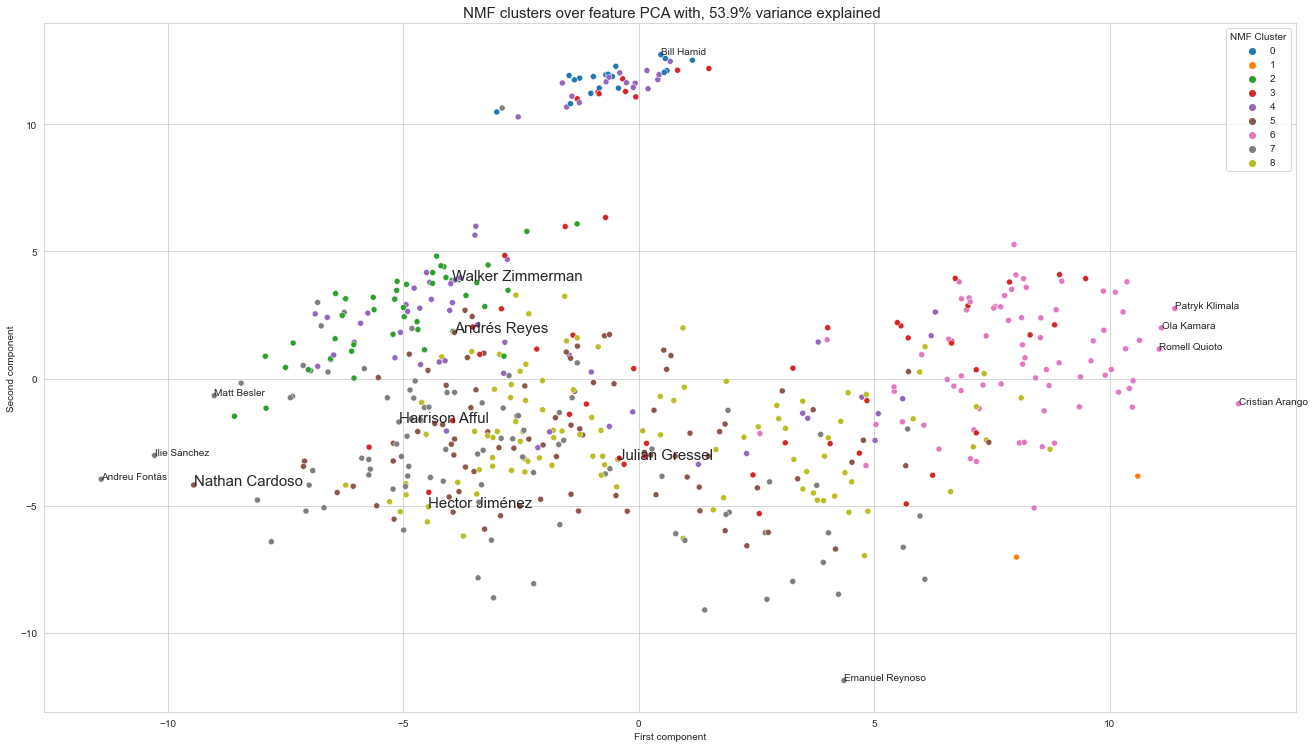

In [8]:
X_scale = scale(X)
def_scaled_df = pd.DataFrame(X_scale, columns=X.columns)
def_pca = PCA().fit(X_scale)

# graph first two components 
def_pca_x = def_pca.transform(X_scale)
def_pca_df = pd.DataFrame(def_pca_x[:,:2])

sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
data = def_pca_x[:,0:2]
x = def_pca_x[:, 0]
y = def_pca_x[:, 1]
p = X.index
df_new['NMF Cluster']=df_new['pred_topic_num']

hue = df_new['NMF Cluster']

pc_var = 100 * def_pca.explained_variance_ratio_.cumsum()[1]
g = sns.scatterplot(data=def_pca_df, x =x, y=y, ax=ax, hue=hue,palette=["C0", "C1", "C2","C3","C4","C5",
                                                                        "C6","C7","C8"])
#                     pallete='YlGnBu')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f' NMF clusters over feature PCA with, {pc_var:.1f}% variance explained',fontsize=15)

players = ['Nathan Cardoso','Hector Jiménez','Harrison Afful','Andrés Reyes','Walker Zimmerman','Julian Gressel']
for p, x, y in zip(p, x, y):
    if p in players:
        plt.annotate(p, (x, y),size=15)
        
    if p not in players:
        if y > 12.647 or y<-10:
            plt.annotate(p, (x, y))
        if x > 11 or x< -9:
            plt.annotate(p,(x,y))

plt.tight_layout()
plt.savefig('../data/images/NMF_clusters_PCA.jpeg')

### 5.3 Insight -
- The image above helps identify clusters of NMF labeled players over the two initial PCA components of feature variance in the X matrix.
- Attacking playmakers in group 6(Attacking Play) are seen on the right side of the graph while identified defenders are on the left side of the graph.
- The Identified defenders are in groups 2(Defensive Actions), and group 5(Tackling). This clustering supports the effectiveness of the NMF decomposition clustering.


## 5.4 Dataframes and Ranks for Radar Plot Comparisons 

### 5.4.1. Create Skill get group ranking Dataframe for players from W matrix

In [9]:
X.head()

,Nineties,xA,Key_pass,Comp_prog,Total_Cmp,Total_Att,Total_Cmp_pct,Total_Tot_Dist,Total_Prg_Dist,Short_Cmp,...,pAdj_def_interceptions,pAdj_Recoveries,pAdj_Aerial_Duels_lost,lost_tackles,True_tackle_pct,pAdj_Tackle_int_blocks,avg_shrt+med_pass_pct,pct_long_balls,prog_carry+lng_comp+crosses,attacking_touches
Carles Gil,25.4,0.472441,5.275591,10.905512,48.818898,65.708661,74.3,1016.102362,390.984252,17.480315,...,1.537525,10.963222,0.267396,0.401093,25.000000,2.406561,84.50,27.022169,24.960630,51.653543
Julian Gressel,29.9,0.408027,3.210702,5.551839,37.324415,57.926421,64.4,812.374582,366.153846,13.879599,...,3.767145,13.905196,1.661976,1.495778,31.506849,7.589689,78.10,30.600462,17.959866,33.143813
Emanuel Reynoso,26.5,0.332075,3.433962,8.830189,42.113208,61.056604,69.0,784.867925,292.981132,19.962264,...,1.658520,12.162481,1.105680,0.982827,34.502924,6.695507,78.50,23.609394,18.792453,55.056604
Albert Rusnák,33.8,0.213018,2.573964,4.289941,40.739645,48.727811,83.6,839.289941,226.863905,16.360947,...,1.304421,10.591897,0.208707,0.417415,32.876712,3.287140,91.15,24.833030,15.355030,30.857988
Maximiliano Moralez,26.5,0.362264,3.132075,7.735849,46.566038,62.415094,74.6,930.830189,318.000000,20.905660,...,1.526455,11.083393,0.663676,1.460088,31.372549,5.043939,83.00,25.634825,18.188679,38.716981


In [25]:
player_ranks = X.copy()

#itterate through X columsn to create ranks of each feature
for col in player_ranks.columns.values:
    title = col +' rank'
    player_ranks[title] = np.round(player_ranks[col].rank(pct=True,na_option='bottom',ascending=True),2) *100
    player_ranks.drop(col,axis=1,inplace=True)



In [26]:
player_ranks.head(4)

,Nineties rank,xA rank,Key_pass rank,Comp_prog rank,Total_Cmp rank,Total_Att rank,Total_Cmp_pct rank,Total_Tot_Dist rank,Total_Prg_Dist rank,Short_Cmp rank,...,pAdj_def_interceptions rank,pAdj_Recoveries rank,pAdj_Aerial_Duels_lost rank,lost_tackles rank,True_tackle_pct rank,pAdj_Tackle_int_blocks rank,avg_shrt+med_pass_pct rank,pct_long_balls rank,prog_carry+lng_comp+crosses rank,attacking_touches rank
Carles Gil,80.0,100.0,100.0,100.0,88.0,96.0,22.0,89.0,90.0,76.0,...,31.0,45.0,11.0,17.0,12.0,13.0,33.0,85.0,100.0,100.0
Julian Gressel,94.0,100.0,99.0,93.0,58.0,89.0,3.0,70.0,86.0,54.0,...,84.0,74.0,49.0,75.0,27.0,63.0,11.0,90.0,98.0,87.0
Emanuel Reynoso,84.0,99.0,100.0,100.0,72.0,92.0,7.0,66.0,70.0,87.0,...,33.0,60.0,31.0,49.0,40.0,50.0,12.0,75.0,99.0,100.0
Albert Rusnák,99.0,91.0,97.0,78.0,68.0,67.0,67.0,72.0,50.0,70.0,...,26.0,41.0,10.0,18.0,34.0,20.0,71.0,79.0,94.0,82.0


In [12]:
skill_sets = pd.read_csv('../data/skill_sets.csv')
columns =['Defensive passing','Dribbling','Defensive actions','Short passing','Playing time','Tackling','Attacking play','Passing volume','Progressive passing']

skill_sets.columns = columns


dfw= pd.DataFrame(W,columns=columns,index = X.index)

for col in dfw.columns.values:
    title = col +' rank'
    dfw[title] = np.round(dfw[col].rank(pct=True,na_option = 'bottom',ascending=True),2) *100
dfw['player_name'] = dfw.index
dfw[['Defensive actions','Defensive actions rank','Tackling',
    'Tackling rank','Defensive passing','Defensive passing rank']].nlargest(5,columns='Defensive actions rank')



,Defensive actions,Defensive actions rank,Tackling,Tackling rank,Defensive passing,Defensive passing rank
Alan Franco,0.319454,100.0,0.262931,74.0,0.029792,81.0
Daniel Steres,0.312552,100.0,0.000000,8.0,0.030987,83.0
Nathan Cardoso,0.359419,100.0,0.605425,99.0,0.027909,79.0
Miles Robinson,0.295821,99.0,0.143919,48.0,0.023461,74.0
Rudy Camacho,0.309299,99.0,0.000000,8.0,0.032558,84.0


In [13]:
dfw.loc[['Nathan Cardoso','Andrés Reyes','Julian Gressel',
        'Guðmundur Þórarinsson','Walker Zimmerman','Steve Birnbaum',
        'Hector Jiménez','Harrison Afful','Graham Zusi']]

,Defensive passing,Dribbling,Defensive actions,Short passing,Playing time,Tackling,Attacking play,Passing volume,Progressive passing,Defensive passing rank,Dribbling rank,Defensive actions rank,Short passing rank,Playing time rank,Tackling rank,Attacking play rank,Passing volume rank,Progressive passing rank,player_name
Nathan Cardoso,0.027909,0.005975,0.359419,0.000000,0.181089,0.605425,0.042522,0.059093,0.000000,79.0,29.0,100.0,8.0,53.0,99.0,50.0,28.0,14.0,Nathan Cardoso
Andrés Reyes,0.027910,0.000000,0.231494,0.095078,0.144881,0.312119,0.071446,0.000000,0.000000,79.0,11.0,89.0,48.0,40.0,81.0,59.0,7.0,14.0,Andrés Reyes
Julian Gressel,0.025871,0.031960,0.042472,0.000000,0.118228,0.103026,0.111820,0.205170,0.728908,77.0,51.0,42.0,8.0,33.0,39.0,66.0,64.0,100.0,Julian Gressel
Guðmundur Þórarinsson,0.016880,0.031751,0.067101,0.112083,0.146450,0.145535,0.041621,0.228972,0.546755,65.0,50.0,53.0,55.0,41.0,48.0,49.0,68.0,99.0,Guðmundur Þórarinsson
Walker Zimmerman,0.038889,0.000000,0.259510,0.017167,0.202172,0.000000,0.141935,0.056289,0.007198,89.0,11.0,94.0,21.0,60.0,8.0,72.0,27.0,31.0,Walker Zimmerman
Steve Birnbaum,0.025453,0.000000,0.230464,0.078168,0.188203,0.000000,0.112439,0.000000,0.000000,76.0,11.0,89.0,43.0,55.0,8.0,67.0,7.0,14.0,Steve Birnbaum
Hector Jiménez,0.005715,0.002340,0.075765,0.115019,0.185050,0.215656,0.028882,0.445139,0.483065,37.0,25.0,57.0,56.0,54.0,63.0,43.0,93.0,97.0,Hector Jiménez
Harrison Afful,0.021968,0.000128,0.111532,0.081642,0.185187,0.149186,0.000000,0.390870,0.302103,72.0,23.0,68.0,45.0,54.0,49.0,13.0,88.0,82.0,Harrison Afful
Graham Zusi,0.021624,0.028114,0.140787,0.022714,0.213993,0.161973,0.000000,0.462167,0.404902,71.0,48.0,76.0,23.0,62.0,51.0,13.0,93.0,92.0,Graham Zusi


- New 2022 San Jose signing Francisco Calvo defensive action rank is close to the recently injured  Natahn Cardoso

### 5.4.2 Normalize W matrix and create key skill maxtrix for radar plots. 

In [14]:
# normalize values 

transformer = Normalizer().fit(W)
normed_W= transformer.transform(W)
# can add back club and salary here 
normed_df = pd.DataFrame(normed_W,index=X.index.values)


df = df = pd.read_csv('../data/final_per_90_and_pAdj.csv')
df.rename(columns={'prog_carry+lng_comp+crosses':'Progressive_play'},inplace=True)
# make df of only key features 
cdf = df[['player_name','Club',
       'Aerial_win_pct',
       'pAdj_Num_Dribblers_tackled',
       'pAdj_Num_Dribbled_past', 'pAdj_Clearences',
       'pAdj_Fouls','pAdj_Recoveries', 'True_tackle_pct',
       'pAdj_Tackle_int_blocks', 'attacking_touches',
       'pct_long_balls','Progressive_play',
       ]].copy()

cdf.rename(columns={'pAdj_Clearences':'Clearences','pAdj_Fouls':'Fouls',
                   'pAdj_Recoveries':'Recoveries',
                  'pAdj_Tackle_int_blocks':'Tackle_int_blocks','pAdj_Num_Dribblers_tackled':'Num_Dribblers_tackled',
                  'pAdj_Num_Dribbled_past':'Num_Dribbled_past'},inplace=True)

#column labels 
params = list(cdf.columns)[2:]

ranks = ['Defensive passing rank', 'Dribbling rank','Defensive actions rank', 'Short passing rank',
       'Tackling rank', 'Attacking play rank', 'Passing volume rank',
       'Progressive passing rank']

## 5.5 Player recomendations from normalized W matrix

### 5.5.1 - Nathan Cordoso, San Jose Earthquakes Center Back

In [15]:
nc = normed_df.loc['Nathan Cardoso']
# use .dot to get cosine simularity 
sims = normed_df.dot(nc)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

,cosine simularity
Nathan Cardoso,1.000000
Andrés Reyes,0.956025
Judson,0.934350
Franco Ibarra,0.903493
Johan Kappelhof,0.900515


findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.


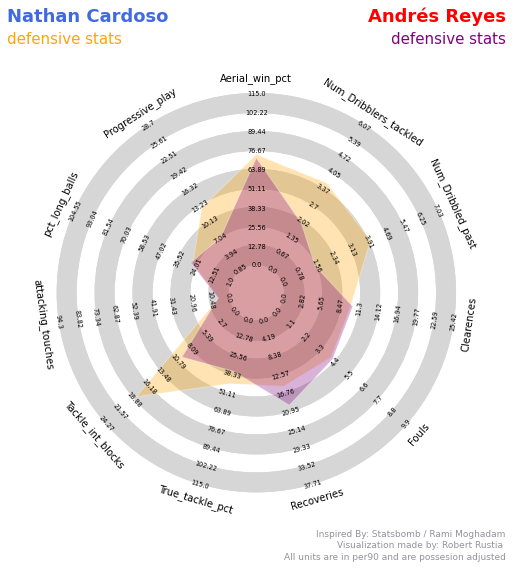

In [16]:
radar_compare('Nathan Cardoso','Andrés Reyes',params,cdf)

### Insight 
 - Both players have very similar player profiles as volume defenders who are thwarting the opposings team attack directly, with both players highlighted in tackles interceptions blocks, recoveries and Aerial_win_pct. 

- Below comparison of skill groups ranks shows both players highlighted for progressive passing and short passing. 

In [28]:
x = player_ranks.loc['Nathan Cardoso']
# [['Comp_prog rank','Total_Cmp rank','Total_Att rank']]
# print(type(x.values))

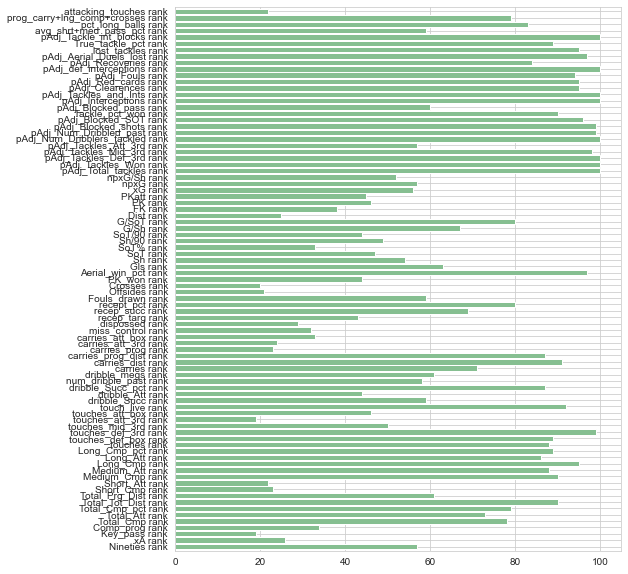

In [29]:
ax = x.plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

#   # Despine
#   ax.spines['right'].set_visible(False)
#   ax.spines['top'].set_visible(False)
#   ax.spines['left'].set_visible(False)
#   ax.spines['bottom'].set_visible(False)

#   # Switch off ticks
#     ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

#   # Draw vertical axis lines
#     vals = ax.get_xticks()
#     for tick in vals:
#         ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

#         # Set x-axis label
#         ax.set_xlabel("Average Trip Duration (Seconds)", labelpad=20, weight='bold', size=12)

#         # Set y-axis label
#         ax.set_ylabel("Start Station", labelpad=20, weight='bold', size=12)

#         # Format y-axis label
#         ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [ ]:
x = ranks.loc[['Nathan Cardoso']][['Comp_prog rank','Total_Cmp rank','Total_Att rank']]
xx=np.reshape(x.values,-1)
print(xx)
labels = ['Comp_prog rank','Total_Cmp rank','Total_Att rank']
men_means = ranks.loc[['Nathan Cardoso']][['Comp_prog rank','Total_Cmp rank','Total_Att rank']]
men_means = men_means.values

print(np.reshape(men_means,-1))
women_means = ranks.loc[['Andrés Reyes']][['Comp_prog rank','Total_Cmp rank','Total_Att rank']]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x = xx, 
                height = men_means, 
#                 width=width, 
                label='Nathan Cardoso')
rects2 = ax.bar(x = x, height = women_means, width=width, label='Andrés Reyes')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


In [ ]:
radar_compare('Nathan Cardoso','Andrés Reyes',ranks,dfw)

### 5.5.2 Julian Gressel, DC united, Wing back

In [ ]:
JG = normed_df.loc['Julian Gressel']
# use .dot to get cosine simularity 
sims = normed_df.dot(JG)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

In [ ]:
radar_compare('Julian Gressel','Guðmundur Þórarinsson',params,cdf)

### Insight - Guðmundur Þórarinsson who now plays for AALBORG BKin the SUPERLIGAEN  after leaving NYC and their successful total campaign is closest to Julian Gressle. Both players are highlighted for their Progressive play on the ball, number of players dribbled past and recoveries. 

In [ ]:
radar_compare('Julian Gressel','Guðmundur Þórarinsson',ranks,dfw)

### 5.5.3 Hector Jimenez , Austin FC , Defender

In [ ]:
HJ = normed_df.loc['Hector Jiménez']
# use .dot to get cosine simularity 
sims = normed_df.dot(HJ)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

In [ ]:
radar_compare('Hector Jiménez','Harrison Afful',params,cdf)

### 5.5.3 Insight 
- Harrison Afful plays as a fullback for Major League Soccer club Charlotte FC and the Ghana national team.
- Both players highlight their Progressive play in the radar above. 
 
- The similarities in skill sets between the two players can be seen below.

In [ ]:
radar_compare('Hector Jiménez','Harrison Afful',ranks,dfw)

## 5.5.4 Walker Zimmerman, Nashville SC - Center Back

In [ ]:
wz = normed_df.loc['Walker Zimmerman']
sims = normed_df.dot(wz)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

In [ ]:
radar_compare('Walker Zimmerman','Steve Birnbaum',params,cdf)

### 5.5.5 Kai Wagner, Philadelphia Union - Left Back 

In [ ]:
wz = normed_df.loc['Kai Wagner']
sims = normed_df.dot(wz)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

In [ ]:
radar_compare('Kai Wagner','Anton Tinnerholm',params,cdf)

### 5.5.6 Graham Zusi, Sporting Kansas City, left wing back

In [ ]:
wz = normed_df.loc['Graham Zusi']
sims = normed_df.dot(wz)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

In [ ]:
radar_compare('Graham Zusi','Harrison Afful',params,cdf)

#### 5.5.6 Insight 
- Grahm Zusi and Hector Jiménez both are very close in cosine similarity to Harrison Afful the Charlotte FC fullback.
- clear similarities in Zusi, who has converted from a midfielder into a deeper lying playmaker and Affuls stats, with almost identical recoveries and attacking touches.
- both players are highlighted for their progressive play making them both suitable for teams looking to play out from the back. 


## 5.6 Identified Player Heatmap Comparison

In [ ]:
 comparisons = dfw.loc[['Nathan Cardoso','Andrés Reyes','Julian Gressel',
                       'Guðmundur Þórarinsson','Walker Zimmerman','Steve Birnbaum',
                      'Hector Jiménez','Harrison Afful','Graham Zusi']]
comparisons.drop('player_name',axis=1,inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
sns.heatmap(comparisons.iloc[:,-9:],annot=True)
plt.title('Player Rank Heatmap')
plt.savefig('../data/images/Player_rank_heat_map.jpeg', pad_inches=0.3)
plt.show()

### 5.6 Insight  
- Heat map allows all defensive players Identified through NMF recomendation can be compared by their NMF feature ranks.

- Many players identified rank in the 90th percentile and above in progressive passing feature rank which included features such as Crosses, touches_att_3rd, attacking_touches, xA. 

- all but two players are between the 70th and  80th percentile in defensive passing feature rank which included  features such as recept_pct, avg_shrt+med_pass_pct, pct_long_balls,touches_def_box, Long_Att,touches_def_3rd. The top percentile players are all Goal keepers so field players were father down the ranking.


### 5.7 conclusion and next steps 

In [ ]:
# Attacking players can also easily be compared with heatmap of skillset  
comparisons = dfw.loc[['Carles Gil','Albert Rusnák','Maximiliano Moralez',
                       'Cristian Arango','Emanuel Reynoso']]
comparisons.drop('player_name',axis=1,inplace=True)
sns.heatmap(comparisons.iloc[:,-9:],annot=True)
plt.title('Attacking Players Rank Heatmap')
plt.savefig('../data/images/Attacking_Players_Rank_Heatmap.jpeg')
plt.show()